This notebook __demonstrates the use of [`nnetsauce`](https://github.com/thierrymoudiki/nnetsauce)'s Adaboost classifier__ on two popular (and public) datasets. `nnetsauce`'s implementation of this algorithm has __some specificities__, as it will be shown in the sequel of this notebook. It is worth noting that the __current implementation is 100% in Python__. 

We start by installing the package's development version from Github (use the command line):

In [0]:
pip install git+https://github.com/thierrymoudiki/nnetsauce.git

Next, we __import the packages necessary for the job__, along with `nnetsauce` (namely `numpy` and `sklearn`, nothing weird!):

In [0]:
import nnetsauce as ns
import numpy as np
from sklearn.datasets import load_breast_cancer, load_wine, load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics


Our __first example__ is based on `wisconsin breast cancer` dataset from [UCI (University of California at Irvine) repository](http://archive.ics.uci.edu/ml/index.php), and available in `sklearn`. More details about the content of these datasets can be found [here](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) and [here](http://archive.ics.uci.edu/ml/datasets/Wine).

`wisconsin breast cancer` dataset is splitted into a __training set__ (for training the model to pattern recognition) and __test set__ (for model validation):

In [0]:
# Import dataset from sklearn
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123)

The first version of Adaboost that we apply is __`SAMME.R`__, also known as Real Adaboost. `SAMME` stands for Stagewise Additive Modeling using a Multi-class Exponential loss function, and  [`nnetsauce`](https://github.com/thierrymoudiki/nnetsauce)'s implementation of this algorithm has some __specificities__:
- The base learners are quasi-randomized (__deterministic__) networks
- At each boosting iteration, a fraction of the datasets' rows or columns can be randomly chosen to increase diversity of the ensemble  

In [0]:
# SAMME.R

# base learner
clf = LogisticRegression(solver='liblinear', multi_class = 'ovr', 
                         random_state=123)

# nnetsauce's Adaboost
fit_obj = ns.AdaBoostClassifier(clf, 
                                n_hidden_features=11, 
                                direct_link=True,
                                n_estimators=250, learning_rate=0.01126343,
                                col_sample=0.72684326, row_sample=0.86429443,
                                dropout=0.63078613, n_clusters=2,
                                type_clust="gmm",
                                verbose=1, seed = 123, 
                                method="SAMME.R")  


The base learner, `clf`, is a logistic regression model. __But it could be anything__, including decision trees. `fit_obj` is a `nnetsauce` object that augments `clf` with a hidden layer, and typically makes its predictions nonlinear. 

`n_hidden_features` is the number of nodes in the hidden layer, and `dropout` randomly drops some of these nodes at each boosting iteration. `col_sample` and `row_sample` specify the __fraction of columns and rows__ chosen for fitting the base learner at each  iteration. With `n_clusters`, the data can be clustered into homogeneous groups before model training.

__`nnetsauce`'s Adaboost can now be fitted__; `250` iterations are used:

In [0]:
# Fitting the model to training set 
fit_obj.fit(X_train, y_train)  

# Obtain model's accuracy on test set
print(fit_obj.score(X_test, y_test))

With the following graph, we can __visualize how well our data have been classified__ by `nnetsauce`'s Adaboost.

250/250 [██████████████████████████████] - 0s 906us/step


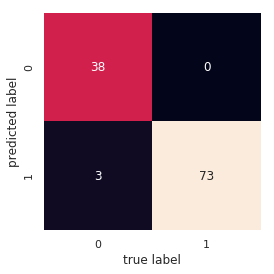

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
preds = fit_obj.predict(X_test)
mat = confusion_matrix(y_test, preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');



`1` denotes a malignant tumor, and `0`, its absence. For the 3 (out of 114) patients remaining missclassified, it could be interesting to change the model `sample_weight`s, in order to give them more weight in the learning procedure. Then, see how well the result evolves;  depending on which decision we consider being the worst (or best). But note that: 
- __The model will never be perfect__ (plus, the labels are based on human-eyed labelling ;) ). 
- Patients are not labelled. _Label_ is just a generic term in classification, for all types of classification models and data. 

Our __second example__ is based on `wine` dataset from [UCI repository](http://archive.ics.uci.edu/ml/index.php). This dataset contains information about wines' quality, depending on their characteristics. `SAMME` is now used instead of `SAMME.R`. This second algorithm seems to require more iterations to converge than `SAMME.R` (but you, tell me from your experience!):

In [0]:
# load dataset
wine = load_wine()
Z = wine.data
t = wine.target
np.random.seed(123)
Z_train, Z_test, y_train, y_test = train_test_split(Z, t, test_size=0.2)


# SAMME
clf = LogisticRegression(solver='liblinear', multi_class = 'ovr', 
                         random_state=123)
fit_obj = ns.AdaBoostClassifier(clf, 
                                n_hidden_features=np.int(8.21154785e+01), 
                                direct_link=True,
                                n_estimators=1000, learning_rate=2.96252441e-02,
                                col_sample=4.22766113e-01, row_sample=7.87268066e-01,
                                dropout=1.56909180e-01, n_clusters=3,
                                type_clust="gmm",
                                verbose=1, seed = 123, 
                                method="SAMME") 
 
 # Fitting the model to training set
fit_obj.fit(Z_train, y_train)  

After fitting the model, we can obtain some statistics (`accuracy`, `precision`, `recall`, `f1-score`; every `nnetsauce` model is 100% `sklearn`-compatible) about it's quality:

In [0]:
preds = fit_obj.predict(Z_test)     
print(metrics.classification_report(preds, y_test))    